# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [1]:
push!(LOAD_PATH, ".")
using PreprocTools
using JLD, PyPlot, Statistics
using ArraySetTools

La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [2]:
abrestring="/home/karel/BRWFiles/Isabel2021/archivos/exper-acido/acido01_121-123_200819.jld"
stringgeneral=replace(abrestring, ".jld"=>"")  

"/home/karel/BRWFiles/Isabel2021/archivos/exper-acido/acido01_121-123_200819"

In [3]:
tamax=400*1024*1024  #maximo tamaño tolerable de archivo
tam=filesize(abrestring)
cachos=div(tam,tamax)+1

1

In [4]:
dicto=load(abrestring)

┌ Warning: type HDF5.Dataset not present in workspace; reconstructing
└ @ JLD /home/karel/.julia/packages/JLD/jeGJb/src/jld_types.jl:697
┌ Warning: type HDF5.File not present in workspace; reconstructing
└ @ JLD /home/karel/.julia/packages/JLD/jeGJb/src/jld_types.jl:697
┌ Warning: type HDF5.Properties not present in workspace; reconstructing
└ @ JLD /home/karel/.julia/packages/JLD/jeGJb/src/jld_types.jl:697


Dict{String,Any} with 2 entries:
  "variables" => Dict{String,Any}("Offset"=>-4125.0,"Factor"=>2.01416,"BRWname"…
  "data"      => Float16[-4.124e3 -4.124e3 … -4.124e3 -4.124e3; 12.086 -2.014 ……

In [5]:
### parametetros globales.
var=dicto["variables"]
freq=var["SamplingRate"]/1000 # Todas las funciones estan en kHz y milisegundos
#cuadrosmax=var["Duration"] # que mergas es esto
datos=dicto["data"];

In [6]:
ncuadros=size(datos,2)
tiempototalms=round(ncuadros/freq; digits=1) 
println("Tienes ", ncuadros, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, " ms." )

Tienes 35711 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  2000.0 ms.


In [7]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.4935175045570116

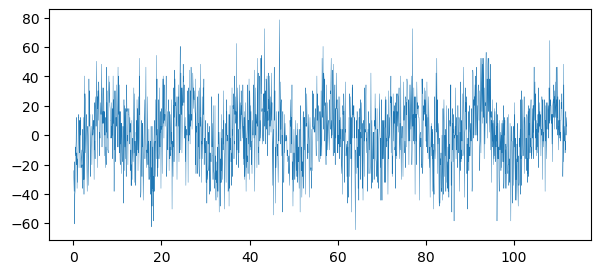

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2d4b6d0ad0>

In [8]:
figure(figsize=(7,3))
range=1:2000
msrange=range./freq
plot(msrange, datos[4,range] , lw=0.3)

In [9]:
datoslfp=convert.(Float32,(reshape(datos, 64,64, ncuadros)));
#Muchas funciones de Statistics VALEN PADRES en float16

In [10]:
function checmal(dats::Array, umbr=1900)
   n=length(findall(x->x>umbr, dats))
    m=length(dats)
    u=n/m
    print(u, " ", n, " ", m, " ")
    return u
end

function bsst(datos::Array, 
                        desde=0.5, hasta=10,
                        freq=deffreq,
                         saturavalue=1900, tol=0.1)
    #busca saturados por promedio sobre umbral
    # cambios para guardar en HDF5 y mandar jld a freir esparragos.
    # no more Sets, only Arrays
    (alto,ancho,largo)=size(datos)
    cini=round(Int, ceil(desde*freq))
    cfin=round(Int, ceil(hasta*freq))
    #result=Set{Array{Int,1}}()
    result=Set(Array{Int8, 1}[])
    for j=1:ancho, k=1:alto
        sepasa=findall(x->x>saturavalue, datos[k,j,cini:cfin])
        enemalos=length(sepasa)
        enetotal=length(cini:cfin)
        fafa=enemalos/enetotal
        if fafa>tol
            print(" ", j," ", k, " => ", fafa, ". " )
            bla=[k, j]
            result=push!(result, bla)
        #    println(prom," ",[k,j]," ",saturavalue," ", desde, " ",hasta)
        end
    end
    #result=permutedims(hcat(result[2:end,:]...), [2,1])
    return result
end


bsst (generic function with 6 methods)

In [11]:
nr=(52, 54, 57, 46)
nc=(28, 28, 33, 44)
for (ren, col) in zip(nr, nc)
    lfpejemplo=vec(datoslfp[ren,col,:])
    print(ren," ", col, " ")
    checmal(lfpejemplo, 3000)
end

52 28 0.0 0 35711 54 28 0.0 0 35711 57 33 0.0 0 35711 46 44 0.0 0 35711 

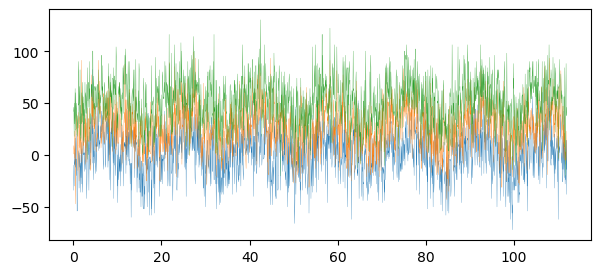

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2d28802c50>

In [12]:
figure(figsize=(7,3))
range=1:2000
rangt=range./freq

plot(rangt,vec(datoslfp[52,28,range]), lw=0.2)
plot(rangt,vec(datoslfp[53,28,range]).+25, lw=0.2)
plot(rangt,vec(datoslfp[54,28,range]).+50, lw=0.2)

In [13]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
PruebaRespuesta=buscaCanalPicos(datoslfp, 1, 200, freq,-110,-900)
# y luego los saturados
iniciobusqueda=1
finbusqueda=282
#satu=bsst(DatosCentrados,iniciobusqueda,finbusqueda,freq,1000, 0.04)

satu=BuscaSaturados(datoslfp,iniciobusqueda,finbusqueda,freq,1000, 0.04)

numerosaturados=length(satu)
println("Encontramos ", numerosaturados, " canales probablemente saturados.")
println("Encontramos ", length(PruebaRespuesta), " canales probablemente con actividad.")


Estoy buscando del cuadro 18 al , 3572
Encontramos 13 canales probablemente saturados.
Encontramos 37 canales probablemente con actividad.


In [14]:
quietos=BuscaSaturadosStd(datoslfp, iniciobusqueda,finbusqueda, freq, 15,10000)
intensos=BuscaSaturadosStd(datoslfp, iniciobusqueda, finbusqueda, freq, 0, 30)
numerosaturados=length(quietos)
println("Encontramos ", numerosaturados, " canales muy quietos")
numerosaturados=length(intensos)
println("Encontramos ", numerosaturados, " canales muy intensos")



Encontramos 21 canales muy quietos
Encontramos 34 canales muy intensos


In [15]:
intersect(quietos, intensos)

Set{Array{Int8,1}} with 0 elements

In [16]:
ruidosos=BuscaRuidosos(datoslfp, iniciobusqueda, finbusqueda, freq,200,15)
numerosaturados=length(ruidosos)
println("Encontramos ", numerosaturados, " canales con ruido alto")

Encontramos 20 canales con ruido alto


### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [17]:
DesviacionPorCanal=zeros(64,64)
for j=1:64
    for k=1:64
        ChorizoExemplo=vec(datoslfp[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
    end
end


In [18]:
std(datoslfp[:,:,3000])

224.2514f0

In [19]:
extrema(DesviacionPorCanal)

(0.0, 2051.136962890625)

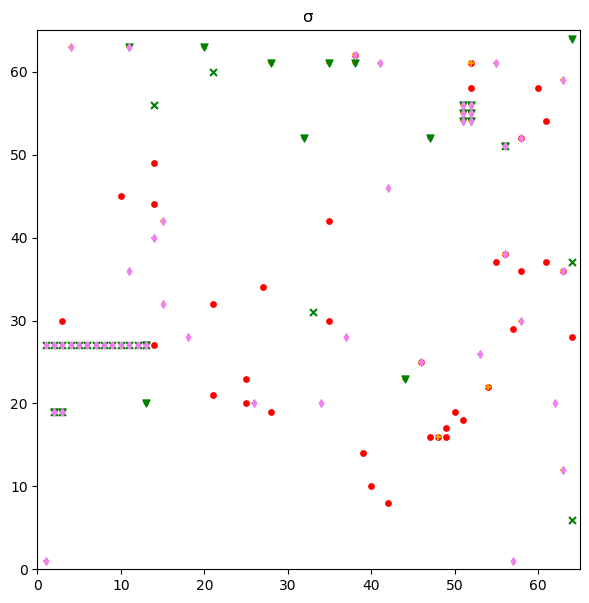

PyObject <matplotlib.collections.PathCollection object at 0x7f2d64f37450>

In [50]:
figure(figsize=(7,7))
xlim(0,65)
ylim(0,65)
title("σ")
limites=200
#imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="cividis", 
#                      vmin=10,vmax=limites, extent=[0.5,64.5,0.5,64.5])
#cb=colorbar()

x=[]
y=[]
for j in PruebaRespuesta
  append!(x,j[2])
   append!(y,j[1])
end


x2=[]
y2=[]
for j in satu
  append!(x2,j[2])
   append!(y2,j[1])
end


x3=[]
y3=[]
for j in quietos
  append!(x3,j[2])
   append!(y3,j[1])
end


x4=[]
y4=[]
for j in intensos
  append!(x4,j[2])
   append!(y4,j[1])
end


x5=[]
y5=[]
for j in ruidosos
  append!(x5,j[2])
   append!(y5,j[1])
end


xisa=[]
yisa=[]
for j in descisa2
  append!(xisa,j[2])
   append!(yisa,j[1])
end





scatter(x,y, marker="o",c="red", s=15)
scatter(x2,y2, marker="o",c="green", s=5)
scatter(x3,y3, marker="x",c="green", s=25)
scatter(x4,y4, marker="+",c="orange", s=25)
scatter(x5,y5, marker="v",c="green", s=25)

scatter(xisa,yisa, marker="d", color="violet", s=15)

"ruidosos" parece ser totalmente redundante. No aporta nada que no sea JUSTO lo que no nos interesa: la union de lo peor y lo mejor.
Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [21]:
helper=load("/home/karel/BRWFiles/Isabel2021/experimentos_acido_seleccionados/acido-200819-01_12-13_sec.jld")

Dict{String,Any} with 5 entries:
  "seleccion"      => [2, 4, 14, 15, 16, 17, 18, 19, 21, 24  …  4070, 4075, 407…
  "descartados"    => [1, 27, 83, 91, 147, 155, 219, 255, 283, 347  …  3517, 35…
  "conteo_canales" => [0, 54, 51, 60, 49, 51, 49, 45, 42, 46  …  49, 42, 53, 51…
  "data"           => Float16[0.0 0.0 … 0.0 0.0; -8.055 -8.055 … 12.086 -4.027;…
  "conteo_frames"  => Any[0, 0, 42, 48, 5, 2, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 0, …

In [24]:
desc_isa=helper["descartados"];

In [44]:
function idxtorowcol(x::Int)
    col,row=divrem(x-1,64).+1
    #col+=1
    return [row, col]
end

function setidxtorowcol(xxs::Array)
    result=Set()
    for x in xxs
        push!(result, idxtorowcol(x))
    end
    return result
end

setidxtorowcol (generic function with 1 method)

In [45]:
descisa2=setidxtorowcol(desc_isa)

Set{Any} with 47 elements:
  [32, 15]
  [38, 56]
  [55, 51]
  [27, 10]
  [36, 63]
  [27, 2]
  [26, 53]
  [51, 56]
  [62, 38]
  [36, 11]
  [27, 13]
  [19, 2]
  [27, 3]
  [56, 51]
  [59, 63]
  [27, 11]
  [27, 1]
  [40, 14]
  [27, 4]
  [52, 58]
  [56, 52]
  [25, 46]
  [28, 18]
  [28, 37]
  [1, 1]
  ⋮ 

In [38]:
ruidosos

Set{Array{Int8,1}} with 20 elements:
  Int8[56, 52]
  Int8[19, 3]
  Int8[23, 44]
  Int8[55, 51]
  Int8[61, 28]
  Int8[64, 64]
  Int8[27, 13]
  Int8[52, 32]
  Int8[54, 51]
  Int8[19, 2]
  Int8[63, 11]
  Int8[20, 13]
  Int8[63, 20]
  Int8[56, 51]
  Int8[61, 35]
  Int8[51, 56]
  Int8[52, 47]
  Int8[61, 38]
  Int8[54, 52]
  Int8[55, 52]

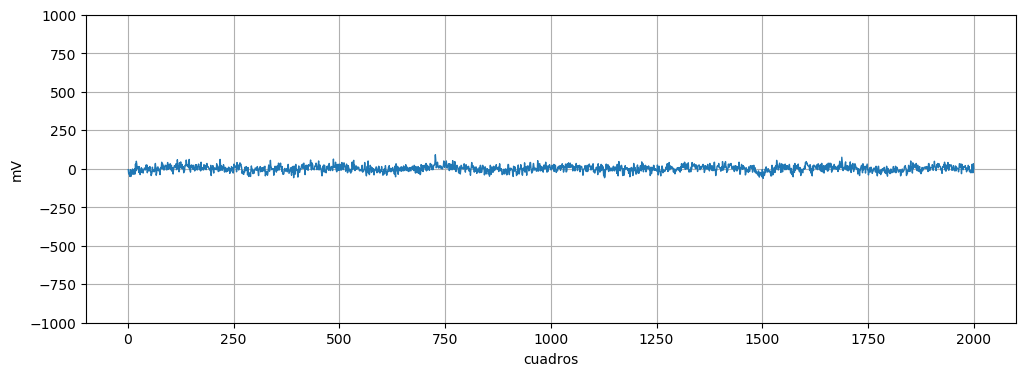

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fca00dafcd0>

In [95]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-1000,1000)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=1
hasta=2000
#intervalo=1:cacho
intervalo=desde:hasta
grid()
plot(intervalo,egtrazo[intervalo], lw=1)

In [96]:
mal=union(quietos, satu)
buenos=union(intensos, PruebaRespuesta)
setdiff!(buenos, mal)

Set{Array{Int8,1}} with 55 elements:
  Int8[56, 52]
  Int8[44, 14]
  Int8[25, 46]
  Int8[19, 28]
  Int8[38, 56]
  Int8[16, 49]
  Int8[17, 49]
  Int8[54, 61]
  Int8[55, 51]
  Int8[36, 63]
  Int8[20, 25]
  Int8[19, 50]
  Int8[1, 1]
  Int8[26, 53]
  Int8[10, 40]
  Int8[16, 47]
  Int8[61, 52]
  Int8[34, 27]
  Int8[58, 52]
  Int8[27, 14]
  Int8[23, 25]
  Int8[30, 35]
  Int8[42, 35]
  Int8[42, 15]
  Int8[29, 57]
  ⋮ 

In [97]:
malforsave=elemtorow(mal)
buenforsave=elemtorow(buenos);

In [99]:
size(datoslfp)

(64, 64, 35711)

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [100]:
dirname(stringgeneral), basename(stringgeneral)

("/home/karel/BRWFiles/Isabel2021/archivos/exper-acido", "acido01_121-123_200819")

In [ ]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
outname=string(dirgen,palabritaespecial, basegen, "_preproc.h5")
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPSaturados" => DatosCentrados[:,:,desde:hasta],
     "desde" => desde,
    "hasta" => hasta,
     "freq" =>freq,
     "CanalesBuenos" => buenforsave,
     "CanalesMalos" => malforsave)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)

In [ ]:
typeof(listaaguardar)

In [ ]:
freq